In [150]:
import pandas as pd


def importar():
    """importa os dados necessários e devolve dois dados: tabela da malária e dados dos municípios
    arg: nenhum
    retunr: df =  tabela pandas para base de dados e municipios = tabela pandas dos municipios e da população por ano."""
    df = pd.read_pickle("dados\Dados_utilizaveis")
    # criar coluna com dados de casos confirmados como 1, outros resultados como 0
    df["detection.numerico"] = df["detection.type"].map(
        {"active": 1, "passive": 0, "CVL": 0}
    )
    municipio = pd.read_pickle("dados\municipio")
    municipio["id_municipio"] = (
        municipio["id_municipio"] // 10
    )  # Tirado ultimo digito do ID para facilitar seu uso, pois não possue diferencia retirar esse digito para o uso final.
    municipios_localizacao = pd.read_csv(
        "dados\municipios_latitude_longitude.csv"
    )  # importar dados de latitudes e longitudes por município
    municipios_localizacao["codigo_ibge"] = (
        municipios_localizacao["codigo_ibge"] // 10
    )  # Tirado ultimo digito do ID para facilitar seu uso, pois não possue diferencia retirar esse digito para o uso final.
    return df, municipio, municipios_localizacao


In [151]:
# criar coluna com ocupação
def populacao(dados, municipio_dados):
    """Devolve uma lista de dados com a população de cada linha, baseado nos municipios e ano
    Arg: dados de casos e dados dos municipios
    return: lista de população"""
    lista_populacao = []
    ano_anterior = 1
    municipio_code_anterio = 1
    for i in range(len(dados)):
        ano_novo = int(dados.loc[i, "data"].year)
        municipio_code_novo = int(dados.loc[i, "infection.county"])
        if (ano_anterior != ano_novo) or (
            municipio_code_anterio != municipio_code_novo
        ):
            logic1 = municipio_dados["ano"] == ano_novo
            logic2 = municipio_dados["id_municipio"] == municipio_code_novo
            populacao_numero = int(municipio_dados.loc[logic1 & logic2]["populacao"])
            ano_anterior = ano_novo
            municipio_code_anterio = municipio_code_novo
        lista_populacao.append(populacao_numero)
    return lista_populacao


In [152]:
def localizacao(dados, municipio_localizacao):
    """Devolve duas lista de dados com a latitude e longitude respectivamente de cada linha, baseado nos municipios
    Arg: dados de casos e dados dos municipios
    return: lista de latitude e lista de longitude"""
    lista_latitude = []
    lista_longitude = []
    municipio_code_anterio = 1
    for i in range(len(dados)):
        municipio_code_novo = int(dados.loc[i, "infection.county"])
        if municipio_code_anterio != municipio_code_novo:
            logic1 = municipio_localizacao["codigo_ibge"] == municipio_code_novo
            latitude_numero = float(municipio_localizacao.loc[logic1]["latitude"])
            longitude_numero = float(municipio_localizacao.loc[logic1]["longitude"])
            municipio_code_anterio = municipio_code_novo
        lista_latitude.append(latitude_numero)
        lista_longitude.append(longitude_numero)
    return lista_latitude, lista_longitude


In [153]:
from sklearn.preprocessing import OneHotEncoder
from seaborn import load_dataset


def onehot_encoder(dados, coluna):
    """Faz o onehot para a coluna espeficidade dentro de um dataframe.
    arg: dados e nome da coluna
    return matrix numpy do onehot da coluna"""
    df = dados[[coluna]]
    ohe = OneHotEncoder()
    transformed = ohe.fit_transform(df)
    merge = transformed.toarray()
    return merge

In [154]:
import numpy as np

df, municipio_dados, municipio_localizacao = importar()
# Apagar dados de 2009
logic2009 = df["notification.year"] != 2009
df = df.loc[logic2009]
# renomear colunas
df.rename(
    columns={"notification.year": "year", "notification.month": "month"}, inplace=True
)
# criar coluna de dias
df["day"] = np.ones(len(df))
# criar coluna de datas e deletar colunas de mes, ano e dias
df["data"] = pd.to_datetime(df[["year", "month", "day"]])
df = df.drop(columns=["month", "year", "day"])
# criar dados trimestrais
dados_finais = df.groupby(
    [pd.Grouper(key="data", freq="Q"), "infection.county", "occupation"]
).sum()
# separar dados por mes
# dados_finais = df.groupby(["data","infection.county", "occupation"]).sum()
# apagar dados com somatoria da detecção igual a 0
logic1 = dados_finais["detection.numerico"] > 0
dados_finais = dados_finais.loc[logic1].reset_index()
# Descobrir população de cada municipio por ano
dados_finais["populacao"] = populacao(dados_finais, municipio_dados)
dados_finais["probabilidade"] = (
    dados_finais["detection.numerico"] / dados_finais["populacao"] * 100
)
latitude, longitude = localizacao(dados_finais, municipio_localizacao)
dados_finais["latitude"] = latitude
dados_finais["longitude"] = longitude
# Onehot Encoder para a coluna occupation
matrix_onehot = onehot_encoder(dados_finais, "occupation")
dados_finais = pd.concat(
    [
        dados_finais,
        pd.DataFrame(
            matrix_onehot, columns=sorted(list(dados_finais["occupation"].unique()))
        ),
    ],
    axis=1,
)


## Separar dados em teste e treino

In [155]:
from sklearn.model_selection import train_test_split

TAMANHO_TESTE = 0.05

indices = dados_finais.index
indices_treino, indices_teste = train_test_split(
    indices, test_size=TAMANHO_TESTE, random_state=41
)

df_treino = dados_finais.loc[indices_treino]
df_teste = dados_finais.loc[indices_teste]

print(df_treino)
print()
print(df_teste)


            data  infection.county         occupation  detection.numerico  \
4823  2011-09-30          110080.0            grazing                  17   
13342 2015-03-31          120042.0              other                 151   
4906  2011-09-30          130002.0  road construction                   2   
13409 2015-03-31          130140.0        agriculture                  33   
19880 2018-06-30          140045.0    domestic worker                 123   
...          ...               ...                ...                 ...   
8513  2012-12-31          110110.0            panning                   4   
21584 2019-03-31          140017.0             mining                   1   
20450 2018-09-30          140020.0        agriculture                  69   
931   2010-06-30          120020.0    domestic worker                  83   
1984  2010-09-30          130270.0        agriculture                  24   

       populacao  probabilidade  latitude  longitude  agriculture  \
4823  


## Separando X (Features) e Y (target) dos dados

In [156]:
import seaborn as sns
from sklearn.model_selection import train_test_split
FEATURES = [ "populacao", "latitude", "longitude", "agriculture", "domestic worker", "grazing", "hunting and fishing", "ignored", "mining", "other", "panning", "road construction", "tourism", "traveler", "vegetal exploitation"]
TARGET = ["probabilidade"]

# observe que usamos o .values aqui pois queremos apenas os valores
X_treino = df_treino.reindex(FEATURES, axis=1).values
y_treino = df_treino.reindex(TARGET, axis=1).values
X_teste = df_teste.reindex(FEATURES, axis=1).values
y_teste = df_teste.reindex(TARGET, axis=1).values

## Baseline
Treinando o modelo

In [157]:
from sklearn.dummy import DummyRegressor

# cria o modelo
modelo_baseline = DummyRegressor()

# treina o modelo
modelo_baseline.fit(X_treino, y_treino)

# realiza uma previsão usando o modelo treinado
previsao = modelo_baseline.predict(X_teste)
print(previsao)

[0.15234889 0.15234889 0.15234889 ... 0.15234889 0.15234889 0.15234889]


Testando o modelo

In [158]:
from sklearn.metrics import mean_squared_error, max_error
from math import sqrt
y_verdadeiro = y_teste
y_previsao = modelo_baseline.predict(X_teste)

RMSE = mean_squared_error(y_verdadeiro, y_previsao, squared=False)
RRMSE = RMSE/sqrt(sum(y_previsao**2))
erro_maximo = max_error(y_verdadeiro, y_previsao)
print(f"O RRMSE do modelo baseline foi de {RRMSE} e o erro maximo foi {erro_maximo}.")

O RRMSE do modelo baseline foi de 0.07166867434495375 e o erro maximo foi 4.326349984567587.


## Modelo linear
Treinando modelo sem normalização de dados

In [159]:
import seaborn as sns
from sklearn.model_selection import train_test_split
FEATURES = [ "populacao", "latitude", "longitude", "agriculture", "domestic worker", "grazing", "hunting and fishing", "ignored", "mining", "other", "panning", "road construction", "tourism", "traveler", "vegetal exploitation"]
TARGET = ["probabilidade"]

# Aqui usamos values aqui pois queremos apenas os valores
X_treino = df_treino.reindex(FEATURES, axis=1).values
y_treino = df_treino.reindex(TARGET, axis=1).values
X_teste = df_teste.reindex(FEATURES, axis=1).values
y_teste = df_teste.reindex(TARGET, axis=1).values

In [160]:
from sklearn.linear_model import LinearRegression

# cria o modelo
modelo_linear = LinearRegression()

# treina o modelo
modelo_linear.fit(X_treino, y_treino)

# realiza uma previsão usando o modelo treinado
previsao = modelo_linear.predict(X_teste)
print(previsao)

[[ 0.45134009]
 [ 0.10367297]
 [ 0.39039944]
 ...
 [ 0.05774722]
 [-0.05397413]
 [ 0.35909452]]


In [161]:
from sklearn.metrics import mean_squared_error, max_error
from math import sqrt
y_verdadeiro = y_teste
y_previsao = modelo_linear.predict(X_teste)

RMSE = mean_squared_error(y_verdadeiro, y_previsao, squared=False)
RRMSE = RMSE/sqrt(sum(y_previsao**2))
erro_maximo = max_error(y_verdadeiro, y_previsao)
print(f"O RRMSE do modelo linear sem normalização foi de {RRMSE} e o erro maximo foi {erro_maximo}.")

O RRMSE do modelo linear sem normalização foi de 0.04838141552028543 e o erro maximo foi 4.103049528753299.


Treinando o modelo com normalização de dados

In [162]:
import seaborn as sns
from sklearn.model_selection import train_test_split
FEATURES = [ "populacao", "latitude", "longitude", "agriculture", "domestic worker", "grazing", "hunting and fishing", "ignored", "mining", "other", "panning", "road construction", "tourism", "traveler", "vegetal exploitation"]
TARGET = ["probabilidade"]

# observe que usamos o .values aqui pois queremos apenas os valores
X_treino = df_treino.reindex(FEATURES, axis=1).values
y_treino = df_treino.reindex(TARGET, axis=1).values
X_teste = df_teste.reindex(FEATURES, axis=1).values
y_teste = df_teste.reindex(TARGET, axis=1).values

In [163]:
from sklearn.preprocessing import MinMaxScaler

normalizador_x = MinMaxScaler()
normalizador_y = MinMaxScaler()

normalizador_x.fit(X_treino)
normalizador_y.fit(y_treino)

MinMaxScaler()

In [164]:
from sklearn.linear_model import LinearRegression

# cria o modelo
modelo_linear = LinearRegression()

# treina o modelo
modelo_linear.fit(
    normalizador_x.transform(X_treino),
    normalizador_y.transform(y_treino),
)

# realiza uma previsão usando o modelo treinado
previsao = modelo_linear.predict(normalizador_x.transform(X_treino))
previsao = normalizador_y.inverse_transform(previsao)
print(previsao)

[[-0.00572505]
 [ 0.45889328]
 [ 0.04828117]
 ...
 [ 0.24163165]
 [ 0.12702305]
 [ 0.17484534]]


In [165]:
from sklearn.metrics import mean_squared_error
from math import sqrt
y_verdadeiro = y_teste
y_previsao = modelo_linear.predict(normalizador_x.transform(X_teste))
y_previsao = normalizador_y.inverse_transform(y_previsao)

RMSE = mean_squared_error(y_verdadeiro, y_previsao, squared=False)
RRMSE = RMSE/sqrt(sum(y_previsao**2))
erro_maximo = max_error(y_verdadeiro, y_previsao)
print(f"O RRMSE do modelo linear com normalização foi de {RRMSE} e o erro maximo foi {erro_maximo}.")

O RRMSE do modelo linear com normalização foi de 0.04818143076422387 e o erro maximo foi 4.10019651780121.


As diferenças entre os modelos lineares com ou sem normalização são praticamente nulas.

Os resultados sem normalização foram: 0.04838141552028543 e o erro maximo foi 4.103049528753299.

Enquanto com normalização foram: 0.04818143076422387 e o erro maximo foi 4.10019651780121.

## $k$-NN
Treinando modelo

Para a construção do modelo $k$-NN, os hiperparâmetros são dados por:
- *n_neighbors* será definido como o número de vizinhos mais próximos utilizado para a análise do modelo;
- *weights* atuará como função de peso para a previsão do modelo, determinado em *uniform* (onde todos os pontos são ponderados igualmente), *distance* (sendo os pontos dados pelo inverso de sua distância, modificando a influência) ou *callable* (que aceita uma matriz de distâncias e sucede em pesos);
- *algorithm* desempenhará o papel de calcular os vizinhos mais próximos, através dos argumentos *ball_tree* e *kd_tree*, os quais desenvolverão problemas de N-pontos generalizados, *brute*, que executará uma pesquisa contínua (de força bruta) e *auto*, para determinar um algoritmo mais apropriado para o processo do método;
- *leaf_size*, pensando na resolução da problemática, o tamanho da "folha" pode ser alterado pelos argumentos *ball_tree* ou *kd_tree*, afetando então a velocidade e a memória do processo;
- *p* é o parâmetro de potência para a métrica Minkowski, onde $p=1$ descreve a *manhattan_distance* e $p=2$ denota a *euclidean_distance*, além da possibilidade de usar com arbitrariedade;
- *metric* como já citado, é a métrica usada para o cálculo de distância;
- por fim, *metric_params* adiciona argumentos de palavra-chave para a função de métrica.

In [166]:
from sklearn.neighbors import KNeighborsRegressor

# cria o modelo
modelo_knn = KNeighborsRegressor(p=1, algorithm="brute")

# treina o modelo
modelo_knn.fit(X_treino, y_treino)

# realiza uma previsão usando o modelo treinado
previsao = modelo_knn.predict(X_teste)
print(previsao)

[[0.12144703]
 [0.04384268]
 [0.00515151]
 ...
 [0.60747829]
 [0.08195522]
 [0.01205636]]


In [167]:
from sklearn.metrics import mean_squared_error

y_verdadeiro = y_teste
y_previsao = modelo_knn.predict(X_teste)


RMSE = mean_squared_error(y_verdadeiro, y_previsao, squared=False)
RRMSE = RMSE/sqrt(sum(y_previsao**2))
erro_maximo = max_error(y_verdadeiro, y_previsao)
print(f"O RRMSE do k-NN foi de {RRMSE} e o erro máximo foi {erro_maximo}.")

O RRMSE do k-NN foi de 0.02311686526337347 e o erro máximo foi 4.582914572864322.


Sendo, então, um valor de RRMSE melhor que o de *baseline*.

In [168]:
NUM_VIZINHOS = [9, 49, 99]

for n in NUM_VIZINHOS:
    modelo_knn = KNeighborsRegressor(n_neighbors=n)

    modelo_knn.fit(X_treino, y_treino)

    y_verdadeiro = y_teste
    y_previsao = modelo_knn.predict(X_teste)
    RMSE = mean_squared_error(y_verdadeiro, y_previsao, squared=False)
    RRMSE = RMSE/sqrt(sum(y_previsao**2))
    erro_maximo = max_error(y_verdadeiro, y_previsao)
    print(f"O RRMSE do k-NN foi de {RRMSE} e o erro máximo foi {erro_maximo}.")

O RRMSE do k-NN foi de 0.02977181271327702 e o erro máximo foi 5.294521523972382.
O RRMSE do k-NN foi de 0.04547966760910705 e o erro máximo foi 3.980434101407407.
O RRMSE do k-NN foi de 0.051887628421246244 e o erro máximo foi 4.069916849555249.


Para melhor visualização

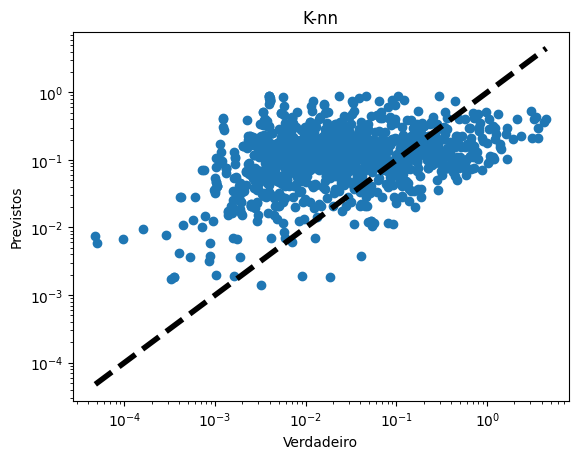

In [169]:
import matplotlib.pyplot as plt

fig, ax = plt.subplots()
ax.scatter(y_verdadeiro, y_previsao)
ax.plot(
    [y_verdadeiro.min(), y_verdadeiro.max()],
    [y_verdadeiro.min(), y_verdadeiro.max()],
    "k--",
    lw=4,
)
ax.set_title("K-nn")
ax.set_xlabel("Verdadeiro")
ax.set_ylabel("Previstos")
# plot em log para melhor visualização
ax.set_yscale("log")
ax.set_xscale("log")
plt.show()


## Para a árvore de decisão primeiramente precisamos definir seus hiperparâmetros.
+ criterion: é o critério utilizado para medir a qualidade de divisão de cada galho, pode ser utilizado qualquer um desses argumentos “squared_error”, “friedman_mse”, “absolute_error”, “poisson”, o melhor depende do modelo que está treinando e devera ser escolhido pela propiá pessoa, como padrão utiliza o “squared_error”.
+ splitter: é a estratégia utilizada para a divisão de cada nó, pode ter dois valores, melhor e aleatório. O melhor escolhe o melhores recursos para se dividir com base na impureza, assim podendo causar overfitting e sobrecarga de processamento no computador, porém é a melhor previsão, já o aleatório divide aleatoriamente assim quase não tendo gasto computacional e diminuindo muito a possibilidade de ocorrer overfitting.
+ max_depth: é a profundidade maxima que árvore terá, se não tiver nenhum valor definido continuará até ter somente folhas puras, ou todas as folas contenham menos de min_samples_split amostras.
+ min_samples_split: é a quantidade mínima de amostra necessária em um nó interno, sendo nó interno uma divisão que pode continuar e nó externo as folhas, onde não continua a divisão, padrão é 2.
+ min_samples_leaf: é parecido com o anterior, porém é o número mínimo de amostra para cada no externo, folha, o padrão é 1.
+ min_weight_fraction_leaf: é a fração ponderada mínima da total de pesos de todas a amostras necessárias para a criação de um nó folha, sendo o valor padrão 0.
+ max_features: é o número máximo de recursos considerados para descobrir a melhor divisão, os recursos selecionados são de forma aleatória, se nenhum max_features = n_features.
+ random_state: não é um hiperparâmetros, porém está na lista, pois é recomendado que defina um valor para este parâmetro para assim ser reprodutível o resultado.
+ max_leaf_nodes: é o número total de folhas que terá na árvore, o padrão é ilimitado.
+ min_impurity_decrease: consegue definir a profundidade máxima da árvore baseado com a impureza, quanto maior o número menor a profundidade e mais geral será a árvore, esse numero dirá para o modelo se a divisão é necessária ou não, o nó sera dividido se a impureza for maior ou igual o valor.
## Agora treinando o modelo

In [170]:
from sklearn.tree import DecisionTreeRegressor
from sklearn.metrics import mean_squared_error, max_error
from math import sqrt

modelo_dt = DecisionTreeRegressor(
    criterion="poisson",
    max_depth=20,
    random_state=41,
)

modelo_dt.fit(X_treino, y_treino)

y_verdadeiro = y_teste
y_previsao = modelo_dt.predict(X_teste)
RMSE = mean_squared_error(y_verdadeiro, y_previsao, squared=False)
RRMSE = RMSE / sqrt(sum(y_previsao**2)) # Fórmula do RRMSE
erro_maximo = max_error(y_verdadeiro, y_previsao)
print(
    f"O RRMSE do modelo árvore de decisão foi de {RRMSE} e o erro maximo foi {erro_maximo}."
)
RRMSE_antes = RRMSE 
erro_maximo_antes = erro_maximo 

O RRMSE do modelo árvore de decisão foi de 0.017176515408519177 e o erro maximo foi 4.785374444707306.


Para melhor visualisação plotamos o grafico de dados previstos por verdadeiros.

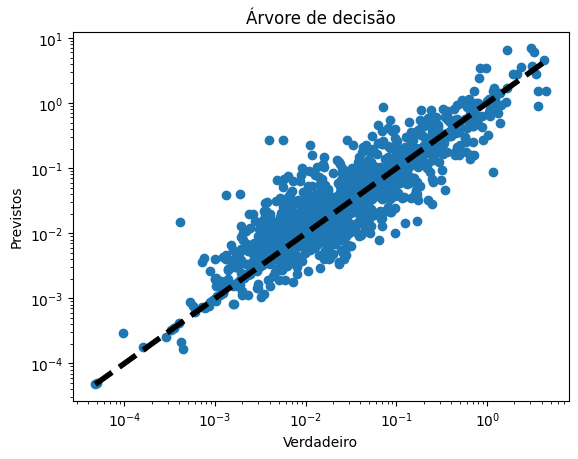

In [171]:
import matplotlib.pyplot as plt

fig, ax = plt.subplots()
ax.scatter(y_verdadeiro, y_previsao)
ax.plot(
    [y_verdadeiro.min(), y_verdadeiro.max()],
    [y_verdadeiro.min(), y_verdadeiro.max()],
    "k--",
    lw=4,
)
ax.set_title("Árvore de decisão")
ax.set_xlabel("Verdadeiro")
ax.set_ylabel("Previstos")
# plot em log para melhor visualização
ax.set_yscale("log")
ax.set_xscale("log")
plt.show()


Testando alguns hiperparâmetros

In [172]:
from itertools import product
list_max_depth = [None] + list(range(50,101))
list_min_samples_split =  list(range(2,10))
list_criterio = ["poisson","squared_error"]
RRMSE_lista = []
erro_maximo_lista = []
parametros = []
for n_max_depth, n_min_samples_split,criterio in product(list_max_depth, list_min_samples_split,list_criterio):
    modelo_dt = DecisionTreeRegressor(
        criterion=criterio,
        random_state=41,
        max_depth = n_max_depth,
        min_samples_split  = n_min_samples_split
    )
    modelo_dt.fit(X_treino, y_treino)
    y_verdadeiro = y_teste
    y_previsao = modelo_dt.predict(X_teste)
    RMSE = mean_squared_error(y_verdadeiro, y_previsao, squared=False)
    RRMSE = RMSE / sqrt(sum(y_previsao**2)) # Fórmula do RRMSE
    erro_maximo = max_error(y_verdadeiro, y_previsao)
    RRMSE_lista.append(RRMSE)
    erro_maximo_lista.append(erro_maximo)
    parametros.append((n_max_depth, n_min_samples_split,criterio))
df_arvore_parametros = pd.DataFrame({"RRMSE": RRMSE_lista,"erro_maximo":erro_maximo_lista,"parametros":parametros}) #para melhor visualização
df_arvore_parametros = df_arvore_parametros.sort_values("RRMSE")
df_arvore_parametros.head(5)

,RRMSE,erro_maximo,parametros
267,0.01707,4.785374,"(65, 7, squared_error)"
635,0.01707,4.785374,"(88, 7, squared_error)"
75,0.01707,4.785374,"(53, 7, squared_error)"
747,0.01707,4.785374,"(95, 7, squared_error)"
331,0.01707,4.785374,"(69, 7, squared_error)"


Portanto a melhor árvore foi

In [173]:
n_max_depth, n_min_samples_split,criterio = df_arvore_parametros["parametros"].iloc[0]
modelo_dt = DecisionTreeRegressor(
    criterion=criterio,
    random_state=41,
    max_depth = n_max_depth,
    min_samples_split  = n_min_samples_split
)
modelo_dt.fit(X_treino, y_treino)
y_verdadeiro = y_teste
y_previsao = modelo_dt.predict(X_teste)
RMSE = mean_squared_error(y_verdadeiro, y_previsao, squared=False)
RRMSE = RMSE / sqrt(sum(y_previsao**2)) # Fórmula do RRMSE
erro_maximo = max_error(y_verdadeiro, y_previsao)
print(
    f"O RRMSE do modelo árvore de decisão foi de {RRMSE}, sendo a diferença deste para o antigo de {RRMSE_antes-RRMSE} e o erro maximo foi {erro_maximo}, diferença de {erro_maximo_antes - erro_maximo}."
)

O RRMSE do modelo árvore de decisão foi de 0.017070497994418163, sendo a diferença deste para o antigo de 0.00010601741410101381 e o erro maximo foi 4.785374444707305, diferença de 8.881784197001252e-16.


Plotando a nova árvore temos

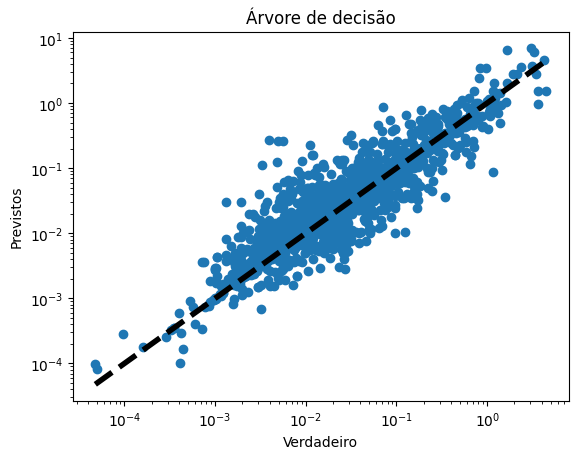

In [174]:
import matplotlib.pyplot as plt

fig, ax = plt.subplots()
ax.scatter(y_verdadeiro, y_previsao)
ax.plot(
    [y_verdadeiro.min(), y_verdadeiro.max()],
    [y_verdadeiro.min(), y_verdadeiro.max()],
    "k--",
    lw=4,
)
ax.set_title("Árvore de decisão")
ax.set_xlabel("Verdadeiro")
ax.set_ylabel("Previstos")
# plot em log para melhor visualização
ax.set_yscale("log")
ax.set_xscale("log")
plt.show()


Considerando o custo computacional, a melhora com hipêrparametros não foi significativa.

Podemos plotar a nossa árvore ficando

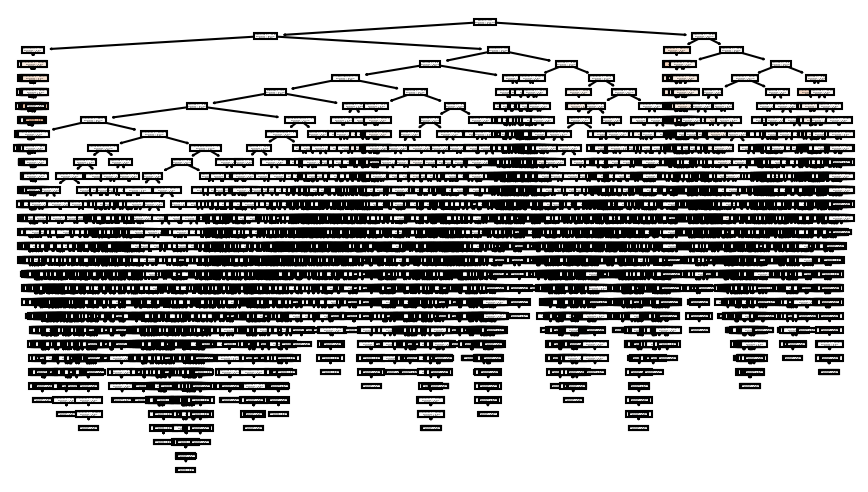

In [175]:
from sklearn import tree
# cria os objetos de figura e eixo
fig, axe = plt.subplots(
    ncols=1,
    nrows=1,
    figsize=(7, 4),
    dpi=150,
)

# plota o grafo da árvore de decisão
tree.plot_tree(
    modelo_dt,
    feature_names=FEATURES,
    ax=axe,
    impurity=False,
    filled=True,
    proportion=True,
    precision=2,
)

# mostra o plot para o usuário
plt.show()

Para conseguir visualizar de uma forma melhor podemos mostrala como texto

In [176]:
from sklearn.tree import export_text

texto_dt = export_text(
    modelo_dt,
    feature_names=FEATURES,
    decimals=2,
)

print(texto_dt)

|--- other <= 0.50
|   |--- longitude <= -72.85
|   |   |--- agriculture <= 0.50
|   |   |   |--- domestic worker <= 0.50
|   |   |   |   |--- populacao <= 18807.50
|   |   |   |   |   |--- populacao <= 17359.00
|   |   |   |   |   |   |--- populacao <= 15380.00
|   |   |   |   |   |   |   |--- value: [0.03]
|   |   |   |   |   |   |--- populacao >  15380.00
|   |   |   |   |   |   |   |--- grazing <= 0.50
|   |   |   |   |   |   |   |   |--- populacao <= 16602.50
|   |   |   |   |   |   |   |   |   |--- populacao <= 15722.00
|   |   |   |   |   |   |   |   |   |   |--- value: [0.02]
|   |   |   |   |   |   |   |   |   |--- populacao >  15722.00
|   |   |   |   |   |   |   |   |   |   |--- value: [0.01]
|   |   |   |   |   |   |   |   |--- populacao >  16602.50
|   |   |   |   |   |   |   |   |   |--- tourism <= 0.50
|   |   |   |   |   |   |   |   |   |   |--- value: [0.02]
|   |   |   |   |   |   |   |   |   |--- tourism >  0.50
|   |   |   |   |   |   |   |   |   |   |--- value: [0.

## Para a floresta de decisão primeiramente precisamos definir seus hiperparâmetros.
+ criterion: é o critério utilizado para medir a qualidade de divisão de cada galho, pode ser utilizado qualquer um desses argumentos “squared_error”, “absolute_error”, “poisson”, o melhor depende do modelo que está treinando e devera ser escolhido pela propiá pessoa, como padrão utiliza o "squared_error".
+ splitter: é a estratégia utilizada para a divisão de cada nó, pode ter dois valores, melhor e aleatório. O melhor escolhe o melhores recursos para se dividir com base na impureza, assim podendo causar overfitting e sobrecarga de processamento no computador, porém é a melhor previsão, já o aleatório divide aleatoriamente assim quase não tendo gasto computacional e diminuindo muito a possibilidade de ocorrer overfitting.
+ max_depth: é a profundidade maxima que árvore terá, se não tiver nenhum valor definido continuará até ter somente folhas puras, ou todas as folas contenham menos de min_samples_split amostras.
+ min_samples_split: é a quantidade mínima de amostra necessária em um nó interno, sendo nó interno uma divisão que pode continuar e nó externo as folhas, onde não continua a divisão, padrão é 2.
+ min_samples_leaf: é parecido com o anterior, porém é o número mínimo de amostra para cada no externo, folha, o padrão é 1.
+ min_weight_fraction_leaf: é a fração ponderada mínima da total de pesos de todas a amostras necessárias para a criação de um nó folha, sendo o valor padrão 0.
+ max_features: é o número máximo de recursos considerados para descobrir a melhor divisão, os recursos selecionados são de forma aleatória, se nenhum max_features = n_features, para cada arvore da floresta.
+ random_state: não é um hiperparâmetros, porém está na lista, pois é recomendado que defina um valor para este parâmetro para assim ser reprodutível o resultado.
+ max_leaf_nodes: é o número total de folhas que terá na árvore, o padrão é ilimitado.
+ min_impurity_decrease: consegue definir a profundidade máxima da árvore baseado com a impureza, quanto maior o número menor a profundidade e mais geral será a árvore, esse numero dirá para o modelo se a divisão é necessária ou não, o nó sera dividido se a impureza for maior ou igual o valor.
+ n_estimators: Numero de arvores na floresta.
+ max_sample:é a fração do conjunto de dados originais fornecida as arvores individual da floresta.
## Agora treinando o modelo

In [177]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error, max_error
from math import sqrt

# alterando o formato do target
print(y_treino.shape, y_teste.shape)
y_treino = y_treino.ravel()
y_teste = y_teste.ravel()
print(y_treino.shape, y_teste.shape)

# cria o modelo
modelo_rf = RandomForestRegressor(random_state=41,n_estimators=3,
        max_leaf_nodes=1000,
        max_depth=40,)

# treina o modelo
modelo_rf.fit(X_treino, y_treino)

# realiza uma previsão usando o modelo treinado
y_verdadeiro = y_teste
y_previsao = modelo_rf.predict(X_teste)
RMSE = mean_squared_error(y_verdadeiro, y_previsao, squared=False)
RRMSE = RMSE / sqrt(sum(y_previsao**2)) # Fórmula do RRMSE
erro_maximo = max_error(y_verdadeiro, y_previsao)
print(
    f"O RRMSE do modelo floresta de decisão foi de {RRMSE} e o erro maximo foi {erro_maximo}."
)
RRMSE_antes = RRMSE 
erro_maximo_antes = erro_maximo 

(22354, 1) (1177, 1)
(22354,) (1177,)
O RRMSE do modelo floresta de decisão foi de 0.019066485330253437 e o erro maximo foi 6.696182139759147.


Plotando o teste para melhor visualização

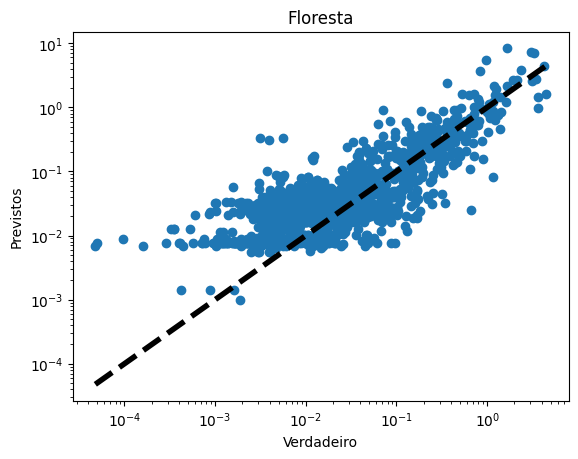

In [178]:
import matplotlib.pyplot as plt

fig, ax = plt.subplots()
ax.scatter(y_verdadeiro, y_previsao)
ax.plot(
    [y_verdadeiro.min(), y_verdadeiro.max()],
    [y_verdadeiro.min(), y_verdadeiro.max()],
    "k--",
    lw=4,
)
ax.set_title("Floresta")
ax.set_xlabel("Verdadeiro")
ax.set_ylabel("Previstos")
# plot em log para melhor visualização
ax.set_yscale("log")
ax.set_xscale("log")
plt.show()


Mesmo ficando estranho o grafico final está melhor que o baseline.

In [179]:
from itertools import product

lista_n_estimators = list(range(50, 101))
lista_max_features = ["sqrt", "log2", None]
list_criterio = ["poisson", "squared_error"]
RRMSE_lista = []
erro_maximo_lista = []
parametros = []
for n_estimators, max_features, criterio in product(
    lista_n_estimators, lista_max_features, list_criterio
):
    modelo_rf = RandomForestRegressor(
        criterion=criterio,
        n_estimators=n_estimators,
        max_features=max_features,
        random_state=41,
        n_jobs=4,
    )

    modelo_rf.fit(X_treino, y_treino)
    y_verdadeiro = y_teste
    y_previsao = modelo_rf.predict(X_teste)
    RMSE = mean_squared_error(y_verdadeiro, y_previsao, squared=False)
    RRMSE = RMSE / sqrt(sum(y_previsao**2))  # Fórmula do RRMSE
    erro_maximo = max_error(y_verdadeiro, y_previsao)
    # add em listas para melhor cassificação
    RRMSE_lista.append(RRMSE)
    erro_maximo_lista.append(erro_maximo)
    parametros.append((n_estimators, max_features, criterio))
df_arvore_parametros = pd.DataFrame(
    {"RRMSE": RRMSE_lista, "erro_maximo": erro_maximo_lista, "parametros": parametros}
)  # para melhor visualização
df_arvore_parametros = df_arvore_parametros.sort_values("RRMSE")
df_arvore_parametros.head(5)

,RRMSE,erro_maximo,parametros
53,0.016844,4.539097,"(58, None, squared_error)"
47,0.016848,4.613839,"(57, None, squared_error)"
35,0.016856,4.669666,"(55, None, squared_error)"
29,0.016856,4.684907,"(54, None, squared_error)"
41,0.016861,4.638969,"(56, None, squared_error)"


Portanto a melhor floresta foi

In [180]:
n_max_depth, n_min_samples_split,criterio = df_arvore_parametros["parametros"].iloc[0]
modelo_rf = RandomForestRegressor(
        criterion=criterio,
        n_estimators=n_estimators,
        max_features=max_features,
        random_state=41,
        n_jobs=4,
    )
modelo_rf.fit(X_treino, y_treino)
y_verdadeiro = y_teste
y_previsao = modelo_rf.predict(X_teste)
RMSE = mean_squared_error(y_verdadeiro, y_previsao, squared=False)
RRMSE = RMSE / sqrt(sum(y_previsao**2)) # Fórmula do RRMSE
erro_maximo = max_error(y_verdadeiro, y_previsao)
print(
    f"O RRMSE do modelo floresta de decisão foi de {RRMSE}, sendo a diferença deste para o antigo de {RRMSE_antes-RRMSE} e o erro maximo foi {erro_maximo}, diferença de {erro_maximo_antes - erro_maximo}."
)

O RRMSE do modelo floresta de decisão foi de 0.017045067247327392, sendo a diferença deste para o antigo de 0.002021418082926045 e o erro maximo foi 4.554256567974072, diferença de 2.141925571785075.


Plotando a nova florsta temos

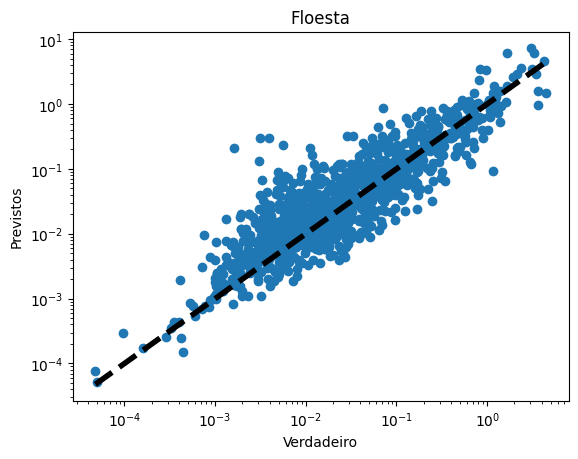

In [181]:
import matplotlib.pyplot as plt

fig, ax = plt.subplots()
ax.scatter(y_verdadeiro, y_previsao)
ax.plot(
    [y_verdadeiro.min(), y_verdadeiro.max()],
    [y_verdadeiro.min(), y_verdadeiro.max()],
    "k--",
    lw=4,
)
ax.set_title("Floesta")
ax.set_xlabel("Verdadeiro")
ax.set_ylabel("Previstos")
# plot em log para melhor visualização
ax.set_yscale("log")
ax.set_xscale("log")
plt.show()


## Comparação

Analisando os valores de RRMSE e de erro máximo de todos os modelos estudados, a **floresta aleatória** teve um melhor desempenho, pois ambos foram valores baixos - em comparação com os demais. Entretanto, se não for necessário uma alta precisão, a **árvore de decisão** pode ser uma escolha mais benéfica, em vista do menor custo operacional evidenciado.

## Classificador

Optamos pela escolha da árvore de decisão, pois na nossa visão, foi o modelo que achamos que melhor encaixou para o modelo de classificação.

array([[<AxesSubplot:title={'center':'probabilidade'}>]], dtype=object)

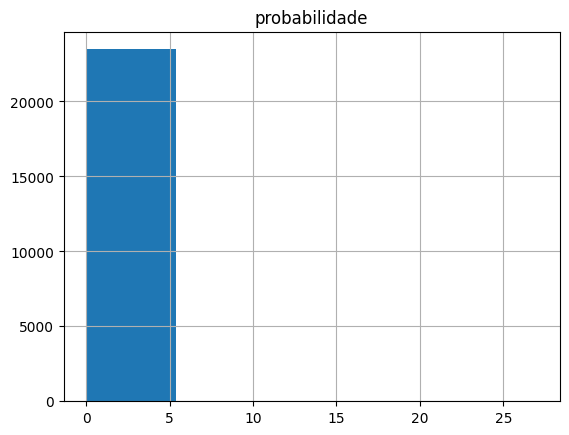

In [182]:
import seaborn as sns
import pandas as pd

TARGET = ["probabilidade"]
dados_finais[TARGET].hist(bins=5)

array([[<AxesSubplot:title={'center':'probabilidade'}>]], dtype=object)

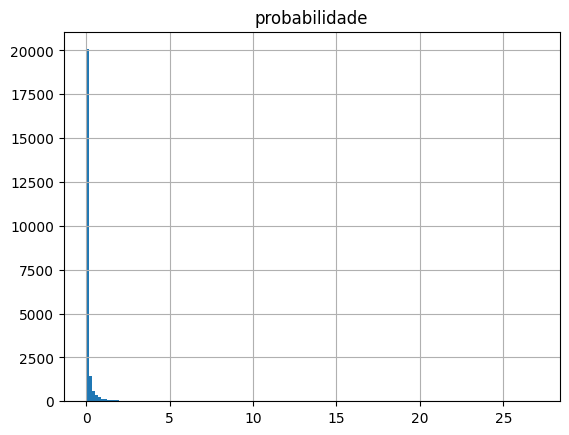

In [183]:
dados_finais[TARGET].hist(bins=150)


In [184]:
logic = dados_finais["probabilidade"] <= 0.005
print(len(dados_finais.loc[logic]),'Chance de infecção muito baixa.')
logic = (dados_finais["probabilidade"] > 0.005) & (dados_finais["probabilidade"] <= 0.05)
print(len(dados_finais.loc[logic]),'Chance de infecção baixa.')
logic = (dados_finais["probabilidade"] > 0.05) & (dados_finais["probabilidade"] <= (dados_finais[ 'probabilidade'].mean()*2))
print(len(dados_finais.loc[logic]),'Chance de infecção média.')
logic = (dados_finais["probabilidade"] > dados_finais[ 'probabilidade'].mean()*2) & (dados_finais["probabilidade"] <= 2.5)
print(len(dados_finais.loc[logic]),'Chance de infecção alta.')
logic = (dados_finais["probabilidade"] > 2.5)
print(len(dados_finais.loc[logic]),'Chance de infecção muito alta.')

5310 Chance de infecção muito baixa.
10845 Chance de infecção baixa.
5054 Chance de infecção média.
2108 Chance de infecção alta.
214 Chance de infecção muito alta.


In [185]:
dados_finais['Categoria de infecção'] = None

logic = dados_finais['probabilidade'] <= 0.005
dados_finais.loc[logic, 'Categoria de infecção'] = 'Chance de infecção muito baixa.'
logic = (dados_finais['probabilidade'] > 0.005) & (dados_finais['probabilidade'] <= 0.05)
dados_finais.loc[logic, 'Categoria de infecção'] = 'Chance de infecção baixa.'
logic = (dados_finais['probabilidade'] > 0.05) & (dados_finais['probabilidade'] <= (dados_finais[ 'probabilidade'].mean()*2))
dados_finais.loc[logic, 'Categoria de infecção'] = 'Chance de infecção média.'
logic = (dados_finais['probabilidade'] > (dados_finais[ 'probabilidade'].mean()*2)) & (dados_finais['probabilidade'] <= 2.5)
dados_finais.loc[logic, 'Categoria de infecção'] = 'Chance de infecção alta.'
logic = (dados_finais['probabilidade'] > 2.5)
dados_finais.loc[logic, 'Categoria de infecção'] = 'Chance de infecção muito alta.'
print(dados_finais)

            data  infection.county       occupation  detection.numerico  \
0     2010-03-31          110001.0      agriculture                   3   
1     2010-03-31          110001.0          grazing                   1   
2     2010-03-31          110002.0      agriculture                  46   
3     2010-03-31          110002.0  domestic worker                  15   
4     2010-03-31          110002.0          grazing                   3   
...          ...               ...              ...                 ...   
23526 2019-12-31          150530.0            other                  55   
23527 2019-12-31          150540.0      agriculture                   1   
23528 2019-12-31          150540.0            other                   3   
23529 2019-12-31          150543.0      agriculture                   1   
23530 2019-12-31          150543.0          panning                  28   

       populacao  probabilidade  latitude  longitude  agriculture  \
0          24392       0.01229

In [186]:
from sklearn.model_selection import train_test_split

TAMANHO_TESTE = 0.05
SEMENTE_ALEATORIA = 41
FEATURES = [
    "populacao",
    "latitude",
    "longitude",
    "agriculture",
    "domestic worker",
    "grazing",
    "hunting and fishing",
    "ignored",
    "mining",
    "other",
    "panning",
    "road construction",
    "tourism",
    "traveler",
    "vegetal exploitation",
]
TARGET = ["Categoria de infecção"]

indices = dados_finais.index
indices_treino, indices_teste = train_test_split(
    indices, test_size=TAMANHO_TESTE, random_state=SEMENTE_ALEATORIA
)

df_treino = dados_finais.loc[indices_treino]
df_teste = dados_finais.loc[indices_teste]

# observe que usamos o .values aqui pois queremos apenas os valores
X_treino = df_treino.reindex(FEATURES, axis=1).values
y_treino = df_treino.reindex(TARGET, axis=1).values.ravel()
X_teste = df_teste.reindex(FEATURES, axis=1).values
y_teste = df_teste.reindex(TARGET, axis=1).values.ravel()

In [187]:
from sklearn.tree import DecisionTreeClassifier

# cria o modelo
modelo_dt = DecisionTreeClassifier(random_state=41,
    max_features="sqrt",
    min_samples_split  = 5)

# treina o modelo
modelo_dt.fit(X_treino, y_treino)

# realiza uma previsão usando o modelo treinado
previsao = modelo_dt.predict(X_teste)
print(previsao)

['Chance de infecção média.' 'Chance de infecção baixa.'
 'Chance de infecção baixa.' ... 'Chance de infecção baixa.'
 'Chance de infecção muito baixa.' 'Chance de infecção baixa.']


In [188]:
from sklearn import metrics

print("Accuracy:",metrics.accuracy_score(y_teste, previsao))

Accuracy: 0.7009345794392523


In [190]:
from sklearn.metrics import confusion_matrix
confusion_matrix(y_teste, previsao)

array([[ 72,   2,   5,   0,  22],
       [  1, 446,   0,  45,  65],
       [  4,   0,   4,   0,   0],
       [  1,  90,   0, 172,   0],
       [ 45,  71,   0,   1, 131]], dtype=int64)

As linhas e as colunas representam o classificado e a referência: os 5 paramêtros de clafissicação de infecção definidos anterioremente.
A diagonal principal representa uma acurácia ok de acertos do algortimo. Ao redor, no triângulo superior e no triângulo inferior, falando de modo matricial, temos os valores preditos erroneamente.